In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BLIP model and processor
loc = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(loc)
model = BlipForConditionalGeneration.from_pretrained(loc)
model = model.to(device)

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [2]:
# Freezing the image encoder and unfreezing the decorder for training
for name, param in model.named_parameters():
    if "vision_model" in name:  
        param.requires_grad = False
    else:
        param.requires_grad = True

In [3]:
# Creating a Dataset class 
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(
            images=item["image"], 
            text=item["text"], 
            padding="max_length", 
            return_tensors="pt"
        )
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        return encoding

In [4]:
# Loading the FACAD fashion dataset from HuggingFace
ds = load_dataset("Luna288/image-captioning-FACAD-base")

# Randomly selecting 10000 images from the large dataset for efficient computation
sampled_ds = ds['train'].shuffle(seed=42).select(range(10000))
shuffled_ds = sampled_ds.shuffle(seed=42)

# Creating a train and test datasets for future use
train_ds = shuffled_ds.select(range(9000))
test_ds = shuffled_ds.select(range(9000, 10000))

# Creating the dataset and dataloader instances
train_dataset = ImageCaptioningDataset(train_ds, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)

# Optimizer for fine-tuning 
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

README.md:   0%|          | 0.00/392 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/123653 [00:00<?, ? examples/s]

In [2]:
# Training loop
model.train()
for epoch in range(2):
    print(f"Epoch: {epoch}")
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss

        print(f"Loss at step {idx}: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Saving the fine-tuned model
model.save_pretrained("path_to_save_finetuned_model")
processor.save_pretrained("path_to_save_finetuned_model")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

trainable params: 161323580 || all params: 247414076 || trainable%: 65.20388112437062


README.md:   0%|          | 0.00/392 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/123653 [00:00<?, ? examples/s]

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss at step 0: 12.846867561340332
Loss at step 1: 10.126176834106445
Loss at step 2: 10.121265411376953
Loss at step 3: 10.109376907348633
Loss at step 4: 10.052148818969727
Loss at step 5: 10.093384742736816
Loss at step 6: 10.001863479614258
Loss at step 7: 10.019686698913574
Loss at step 8: 9.402217864990234
Loss at step 9: 9.101845741271973
Loss at step 10: 8.673443794250488
Loss at step 11: 8.458909034729004
Loss at step 12: 8.147883415222168
Loss at step 13: 7.768534183502197
Loss at step 14: 7.4746270179748535
Loss at step 15: 7.344229221343994
Loss at step 16: 6.946753978729248
Loss at step 17: 6.694444179534912
Loss at step 18: 6.45393705368042
Loss at step 19: 6.202473163604736
Loss at step 20: 5.917923927307129
Loss at step 21: 5.680355072021484
Loss at step 22: 5.41904878616333
Loss at step 23: 5.178287982940674
Loss at step 24: 4.9309983253479
Loss at step 25: 4.6523308753967285
Loss at step 26: 4.381998062133789
Loss at step 27: 4.158817768096924
Loss at step 28: 3.87819

[]

In [3]:
# Logging into HuggingFace
from huggingface_hub import login

login()

In [5]:
# Creating a HuggingFace repository for my model
from huggingface_hub import create_repo

repo_id = "sagniksengupta/blip-finetuned-facad"
create_repo(repo_id)

RepoUrl('https://huggingface.co/sagniksengupta/blip-finetuned-facad', endpoint='https://huggingface.co', repo_type='model', repo_id='sagniksengupta/blip-finetuned-facad')

In [6]:
from transformers import BlipForConditionalGeneration, BlipProcessor

# Loading my locally saved model and processor
model = BlipForConditionalGeneration.from_pretrained("path_to_save_finetuned_model")
processor = BlipProcessor.from_pretrained("path_to_save_finetuned_model")

# Pushing the model to the HuggingFace Hub
model.push_to_hub(repo_id)
processor.push_to_hub(repo_id)

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sagniksengupta/blip-finetuned-facad/commit/6ebf3a5b8d5997ce03af84186beedeeac0bcc2dd', commit_message='Upload processor', commit_description='', oid='6ebf3a5b8d5997ce03af84186beedeeac0bcc2dd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sagniksengupta/blip-finetuned-facad', endpoint='https://huggingface.co', repo_type='model', repo_id='sagniksengupta/blip-finetuned-facad'), pr_revision=None, pr_num=None)

In [7]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

# Loading my custom model from HuggingFace for inference on an image
model = BlipForConditionalGeneration.from_pretrained("sagniksengupta/blip-finetuned-facad")
processor = BlipProcessor.from_pretrained("sagniksengupta/blip-finetuned-facad")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

config.json:   0%|          | 0.00/672 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

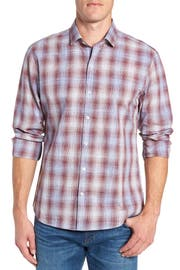

In [23]:
# Loading a test image from the testing dataset
example = test_ds[420]
image = example["image"]
image

In [24]:
# Generating the caption for the test image
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_caption

'a handsome plaid print mark a handsome sport tee cut from a stretchy cotton blend and fitted with a spread collar and spread collar'

In [18]:
# Saving the train and test datasets splits for future inference
train_ds.to_parquet("path_to_save_train_dataset/train_dataset.parquet")
test_ds.to_parquet("path_to_save_test_dataset/test_dataset.parquet")

Creating parquet from Arrow format:   0%|          | 0/90 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

6582061